# 今回の取り組み

- `consensus`でシークエンスエラー部位の補正を行います

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
pip uninstall -qy DAJIN2
# pip install -q -e .
# pipの更新
# pip install -q -U pip
# pip install -q -U -r requirements.txt

# 実験

In [5]:
from __future__ import annotations
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report

#### * flox insertion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/flox-cables2/AyabeTask1/barcode31.fq.gz",
    "examples/flox-cables2/AyabeTask1/barcode42.fq.gz",
    "examples/flox-cables2/AyabeTask1/design_cables2.fa",
    "single-ayabetask1",
    "mm10",
    True,
    14,
)



######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "midsv_corrected", "report", "result", "mutation_loci"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-ayabetask1...


In [10]:
import pickle
path_mut = "DAJINResults/.tempdir/single-ayabetask1/mutation_loci/barcode31.plk"
with open(path_mut, "rb") as f:
    MUTATION_LOCI_ALLELES = pickle.load(f)

In [19]:
allele = "flox"
print(FASTA_ALLELES[allele].index("CCCCCCTCCCC"))
print(FASTA_ALLELES[allele].index("CCCCCCTAGATA"))

461
851


In [20]:
print(MUTATION_LOCI_ALLELES[allele][455:465])
print(MUTATION_LOCI_ALLELES[allele][845:855])

[{'*'}, {'*'}, set(), {'*'}, set(), set(), set(), set(), set(), set()]
[set(), set(), set(), {'+'}, set(), set(), set(), set(), set(), set()]


- たしかにホモポリマー領域付近には欠失`{-}`の変異はありません
- この情報をコンセンサス配列に活かします

In [23]:
classif_sample = classification.classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)
clust_sample = clustering.add_labels(
        classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS
    )
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

In [21]:
from __future__ import annotations

import re
from collections import defaultdict
from itertools import groupby


def _call_percentage(cssplits: list[str], mutation_loci) -> list[dict[str, float]]:
    """
    Call position weight matrix in defferent loci.
    Non defferent loci are annotated to "Match" or "Unknown(N)"
    """
    cssplits_transposed = [list(cs) for cs in zip(*cssplits)]
    coverage = len(cssplits)
    cons_percentage = []
    for cs_transposed in cssplits_transposed:
        count_cs = defaultdict(float)
        for cs in cs_transposed:
            count_cs[cs] += 1 / coverage * 100
        count_cs_sorted = dict(sorted(count_cs.items(), key=lambda x: x[1], reverse=True))
        cons_percentage.append(count_cs_sorted)

In [33]:
print(len(clust_sample))
print(clust_sample[0])

994
{'QNAME': '002cbd51-86c7-4063-931b-12707594322c', 'CSSPLIT': '=G,=G,=C,=A,=A,=G,=A,=A,=C,=G,=A,=C,=C,=T,=G,=C,=T,=T,=T,=T,=T,=A,=C,=C,=T,=T,=A,=C,=A,=G,=A,=A,=C,=C,=A,=A,=G,=C,=A,=T,=G,=C,=A,=T,=C,=T,-G,=G,=A,=T,=C,=A,=C,=C,=A,=A,=G,=A,=C,=A,=C,=A,=A,=A,=G,=G,=C,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=C,=C,=C,=A,=C,=T,=T,=C,=A,=T,=C,=A,=A,=G,=A,=A,=C,=A,=T,=G,=A,=G,=G,=C,=A,=G,=T,=A,=T,=G,=A,=C,=A,=C,=A,=A,=A,=G,=A,=A,=C,=A,=G,=C,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=G,=T,=A,=G,=G,=G,=C,=C,=A,=G,=G,=C,=C,=C,=G,=G,=G,=A,=A,=G,=G,=C,=C,=A,=C,=T,=G,=T,=G,=C,-T,=C,=C,=C,-T,=G,=T,=A,=C,=T,=G,=T,=A,=G,=G,=A,=T,=C,=A,=G,=G,=C,=C,=G,=T,=G,=T,=C,=T,=C,=T,-G,=G,=G,=G,=G,=C,=C,=A,=A,=A,=A,=A,=T,=A,=T,=G,=A,=G,=A,=C,=C,=C,=A,=G,=G,=C,=C,=C,=T,=G,=C,=C,*CT,=C,-T,=G,=T,=T,=G,=G,=C,=A,=G,=C,=A,=G,=C,=C,=C,=C,=T,=T,=C,=T,=C,=C,=A,=T,=C,=A,=C,=C,=C,=G,=T,=T,=G,=T,=C,=C,=C,=C,=T,=G,=A,-C,=C,=C,=T,=C,=T,=A,=T,=A,=T,=T,=G,=T,=T,=G,=A,=A,=C,=A,=C,=T,=G,=G,=C,*TC,=A,=G,=C,=A,=T,=A,=G,=C,=C,=A,=G,=G,=C,=C,=A,=G,=C

In [54]:
cssplits = [cs["CSSPLIT"].split(",") for cs in clust_sample if cs["ALLELE"] == "flox"]
mutation_loci = MUTATION_LOCI_ALLELES["flox"]

In [62]:
cssplits_transposed = [list(cs) for cs in zip(*cssplits)]
coverage = len(cssplits)
cons_percentage = []
for cs_transposed, mut_loci in zip(cssplits_transposed, mutation_loci):
    count_cs = defaultdict(float)
    for cs in cs_transposed:
        if cs[0] in {"+", "-", "*"} and cs[0] not in mut_loci:
            cs = "@"
        count_cs[cs] += 1 / coverage * 100
    count_cs_sorted = dict(sorted(count_cs.items(), key=lambda x: x[1], reverse=True))
    cons_percentage.append(count_cs_sorted)

In [121]:
from collections import Counter
print(Counter(cssplits_transposed[461]))
print(cons_percentage[461])
print(cons_percentage[851])

Counter({'-C': 398, '=C': 154, '*CT': 7, '+C|=C': 3, '+G|=C': 2, '*CG': 1, '*CA': 1})
{'@': 72.79151943462935, '=C': 27.208480565371087}
{'@': 67.84452296819822, '=C': 32.155477031802214}


In [119]:
cons_percentage_updated = []
for dict_percentage in cons_percentage:
    if "@" not in dict_percentage:
        cons_percentage_updated.append(dict_percentage)
        continue
    dict_percentage_update = dict()
    div = 100 / (100 - dict_percentage["@"])
    for key, val in dict_percentage.items():
        if key == "@":
            continue
        dict_percentage_update[key] = round(val * div, 5)
    cons_percentage_updated.append(dict_percentage_update)


In [123]:
print(cons_percentage_updated[461])
print(cons_percentage_updated[851])

{'=C': 100.0}
{'=C': 100.0}


In [140]:
from __future__ import annotations

import re
from collections import defaultdict
from itertools import groupby


def _call_percentage(cssplits: list[str], mutation_loci) -> list[dict[str, float]]:
    """call position weight matrix in defferent loci.
    - non defferent loci are annotated to "Match" or "Unknown(N)"
    - sequence errors are annotated to "@"
    """
    cssplits_transposed = [list(cs) for cs in zip(*cssplits)]
    coverage = len(cssplits)
    cons_percentage = []
    for cs_transposed, mut_loci in zip(cssplits_transposed, mutation_loci):
        count_cs = defaultdict(float)
        for cs in cs_transposed:
            if cs[0] in {"+", "-", "*"} and cs[0] not in mut_loci:
                cs = "@"
            count_cs[cs] += 1 / coverage * 100
        count_cs_sorted = dict(sorted(count_cs.items(), key=lambda x: x[1], reverse=True))
        cons_percentage.append(count_cs_sorted)
    return cons_percentage


def _replace_percentage(cons_percentage: list[dict[str, float]]) -> list[dict[str, float]]:
    """replace sequence error as distributing according to proportion of cs tags"""
    cons_percentage_updated = []
    for dict_percentage in cons_percentage:
        if "@" not in dict_percentage:
            cons_percentage_updated.append(dict_percentage)
            continue
        dict_percentage_update = dict()
        div = 100 / (100 - dict_percentage["@"])
        for key, val in dict_percentage.items():
            if key == "@":
                continue
            dict_percentage_update[key] = round(val * div, 5)
        cons_percentage_updated.append(dict_percentage_update)
    return cons_percentage_updated


def _call_sequence(cons_percentage: list[dict[str, float]]) -> str:
    consensus_sequence = []
    for cons_per in cons_percentage:
        cons = max(cons_per, key=cons_per.get)
        if cons.startswith("="):
            cons = cons.replace("=", "")
        elif cons.startswith("-"):
            continue
        elif cons.startswith("*"):
            cons = cons[-1]
        elif cons.startswith("+"):
            cons_ins = cons.split("|")
            if cons_ins[-1].startswith("="):
                cons = cons.replace("=", "")
            elif cons_ins[-1].startswith("-"):
                cons = "".join(cons_ins[:-1])
            elif cons_ins[-1].startswith("*"):
                cons = "".join([*cons_ins[:-1], cons_ins[-1][-1]])
            cons = cons.replace("+", "")
            cons = cons.replace("|", "")
        consensus_sequence.append(cons)
    return "".join(consensus_sequence)


def _detect_sv(cons_percentage: defaultdict[list], threshold: int = 50) -> list[bool]:
    exists_sv = []
    for cons_per in cons_percentage.values():
        cons_cssplits = []
        for cssplit in cons_per:
            seq = max(cssplit, key=cssplit.get)
            cons_cssplits.append(seq)
        cons_cssplits = "".join(cons_cssplits)
        if "N" * threshold in cons_cssplits:
            exists_sv.append(True)
        elif re.search(rf"(\+[ACGTN]\|){{{threshold}}}", cons_cssplits):
            exists_sv.append(True)
        elif re.search(rf"(\-[ACGTN]){{{threshold}}}", cons_cssplits):
            exists_sv.append(True)
        elif re.search(rf"(\*[ACGTN][ACGTN]){{{threshold}}}", cons_cssplits):
            exists_sv.append(True)
        elif re.search(r"[acgtn]", cons_cssplits):
            exists_sv.append(True)
        else:
            exists_sv.append(False)
    return exists_sv


###########################################################
# main
###########################################################


def call_consensus(clust_sample: list[dict], MUTATION_LOCI_ALLELES) -> tuple[defaultdict[list], defaultdict[str]]:
    cons_percentage = defaultdict(list)
    cons_sequence = defaultdict(str)
    clust_sample.sort(key=lambda x: x["LABEL"])
    for _, group in groupby(clust_sample, key=lambda x: x["LABEL"]):
        clust = list(group)
        keys = (
            clust[0]["ALLELE"],
            clust[0]["LABEL"],
            clust[0]["PERCENT"],
        )
        mutation_loci = MUTATION_LOCI_ALLELES[clust[0]["ALLELE"]]
        cssplits = [cs["CSSPLIT"].split(",") for cs in clust]
        cons_per = _call_percentage(cssplits, mutation_loci)
        cons_per = _replace_percentage(cons_per)
        cons_seq = _call_sequence(cons_per)
        cons_percentage[keys] = cons_per
        cons_sequence[keys] = cons_seq
    return cons_percentage, cons_sequence


In [141]:

cons_percentage, cons_sequence = call_consensus(clust_sample, MUTATION_LOCI_ALLELES)

In [147]:
print(cons_percentage[('flox', 1, 52.113)][461])
print(cons_percentage[('flox', 1, 52.113)][851])

{'=C': 100.0}
{'=C': 100.0}


In [149]:
%%bash
rm -rf DAJINResults/single-ayabetask1
rm -rf DAJINResults/.tempdir/single-ayabetask1

pip install -qe .

time DAJIN2 \
    --name single-ayabetask1 \
    --sample examples/flox-cables2/AyabeTask1/barcode31.fq.gz \
    --control examples/flox-cables2/AyabeTask1/barcode42.fq.gz \
    --allele examples/flox-cables2/AyabeTask1/design_cables2.fa \
    --genome mm10 \
    --threads 10

examples/flox-cables2/AyabeTask1/barcode42.fq.gz is now processing...
2023-05-17 14:57:49: Preprocess barcode42...
2023-05-17 14:57:49: Mapping barcode42...
2023-05-17 14:57:53: Call MIDSV barcode42...
examples/flox-cables2/AyabeTask1/barcode42.fq.gz is finished!
examples/flox-cables2/AyabeTask1/barcode31.fq.gz is now processing...
2023-05-17 14:57:58: Preprocess barcode31...
2023-05-17 14:58:12: Classify barcode31...
2023-05-17 14:58:12: Clustering barcode31...
2023-05-17 14:58:17: Consensus calling barcode31......
examples/flox-cables2/AyabeTask1/barcode31.fq.gz is finished...


Finished! Open DAJINResults/single-ayabetask1 to see the report.

real	0m39.675s
user	0m26.177s
sys	0m1.040s


- 無事にシークエンスエラーを除くことができました

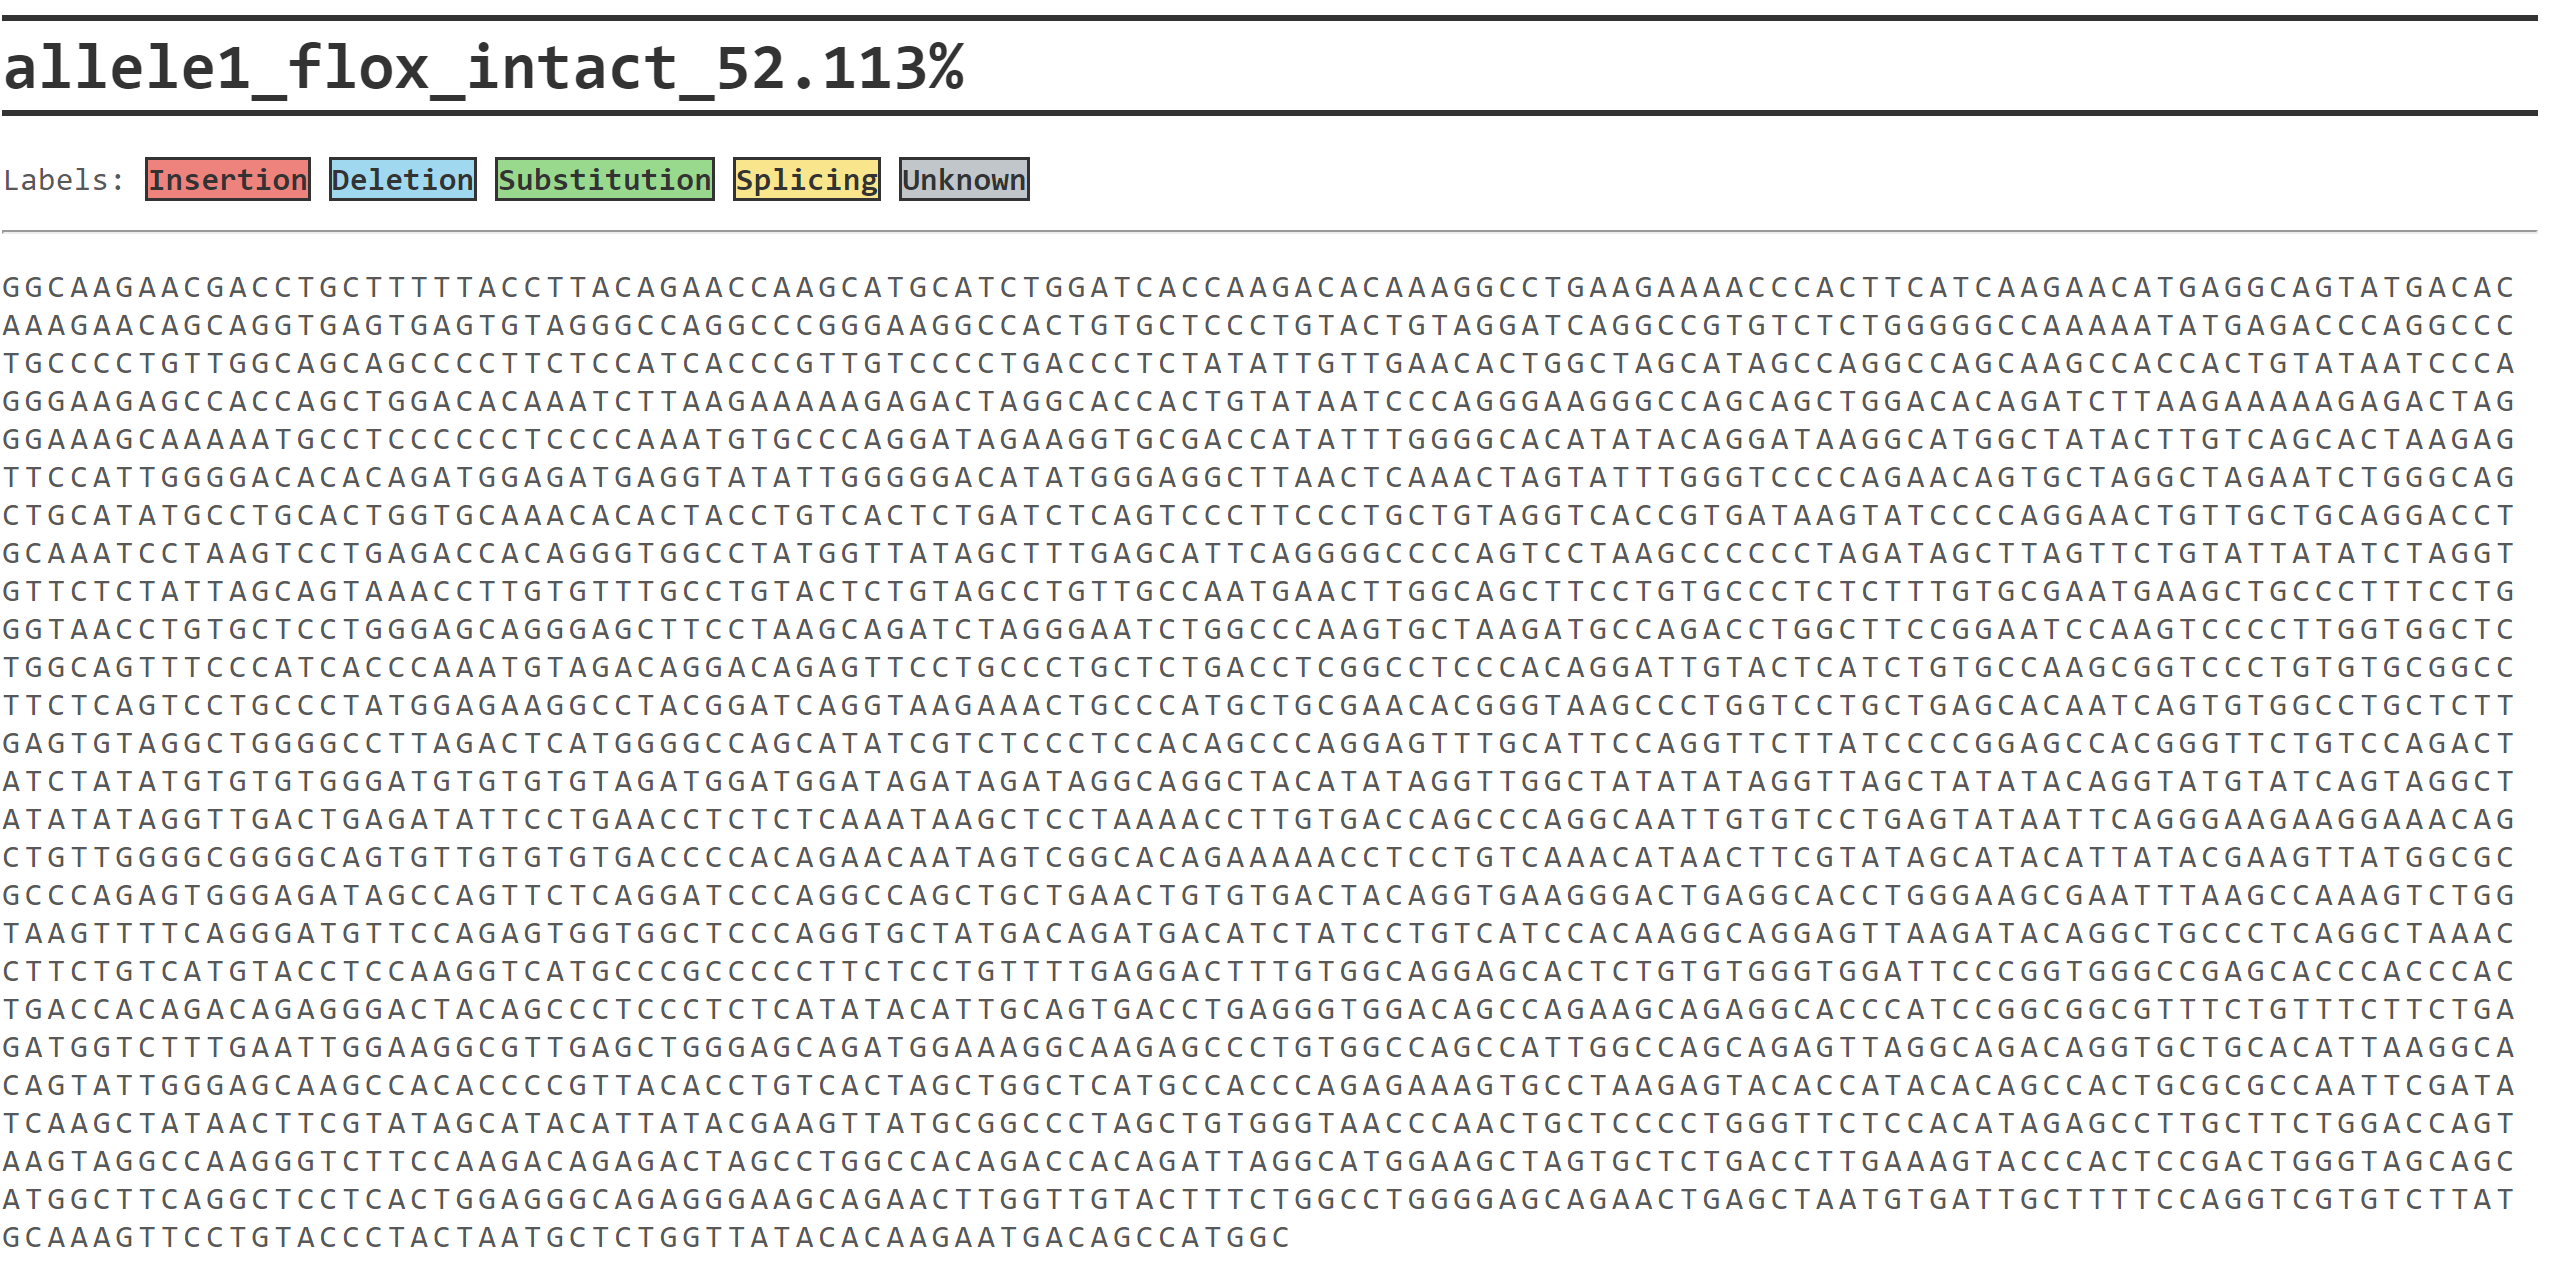

In [158]:
%%bash
pip install -qe .
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
2023-05-17 15:04:12: Preprocess test_barcode30...
2023-05-17 15:04:12: Mapping test_barcode30...
2023-05-17 15:04:22: Call MIDSV test_barcode30...
tests/data/knockout/test_barcode30.fq.gz is finished!
tests/data/knockout/test_barcode25.fq.gz is now processing...
2023-05-17 15:04:31: Preprocess test_barcode25...
2023-05-17 15:05:13: Classify test_barcode25...
2023-05-17 15:05:16: Clustering test_barcode25...
2023-05-17 15:05:24: Consensus calling test_barcode25......


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 276, in main
    _execute_single_mode(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 42, in _execute_single_mode
    core_execute.execute_sample(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 172, in execute_sample
    cons_percentage, cons_sequence = consensus.call_consensus(clust_subset_sample, MUTATION_LOCI_ALLELES)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/consensus/consensus.py", line 113, in call_consensus
    cons_seq = _call_sequence(cons_per)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/consensus/consensus.py", line 49, in _call_sequence
    cons = max(cons_per, key=cons_per.get)
ValueError: max() arg is an empty sequence

real	1m21.225s
user	1m6.652s
sys	0m0.992s


CalledProcessError: Command 'b'pip install -qe .\nrm -rf DAJINResults/single-stx2deletion\nrm -rf DAJINResults/.tempdir/single-stx2deletion\n\ntime DAJIN2 \\\n    --name single-stx2deletion \\\n    --sample "tests/data/knockout/test_barcode25.fq.gz" \\\n    --control "tests/data/knockout/test_barcode30.fq.gz" \\\n    --allele "tests/data/knockout/design_stx2.fa" \\\n    --genome mm10 \\\n    --threads 10\n'' returned non-zero exit status 1.

- STX2でエラーです…

In [161]:
##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "single-stx2deletion",
    "mm10",
    True,
    30,
)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "midsv_corrected", "report", "result", "mutation_loci"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

In [162]:
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [163]:
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)

In [164]:
classif_sample = classification.classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [165]:
clust_sample = clustering.add_labels(
    classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS
)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

In [166]:
from itertools import groupby


def subset_clust(clust_sample, num: int = 1000):
    clust_subset_sample = []
    clust_sample.sort(key=lambda x: x["LABEL"])
    for _, group in groupby(clust_sample, key=lambda x: x["LABEL"]):
        clust_subset_sample.extend(list(group)[:num])
    return clust_subset_sample

clust_subset_sample = subset_clust(clust_sample, 1000)

In [168]:
cons_percentage, cons_sequence = call_consensus(clust_subset_sample, MUTATION_LOCI_ALLELES)

ValueError: max() arg is an empty sequence

In [169]:
cons_percentage = defaultdict(list)
cons_sequence = defaultdict(str)
clust_sample.sort(key=lambda x: x["LABEL"])
for _, group in groupby(clust_sample, key=lambda x: x["LABEL"]):
    clust = list(group)
    keys = (
        clust[0]["ALLELE"],
        clust[0]["LABEL"],
        clust[0]["PERCENT"],
    )
    mutation_loci = MUTATION_LOCI_ALLELES[clust[0]["ALLELE"]]
    cssplits = [cs["CSSPLIT"].split(",") for cs in clust]
    cons_per = _call_percentage(cssplits, mutation_loci)
    cons_per = _replace_percentage(cons_per)
    cons_seq = _call_sequence(cons_per)

ValueError: max() arg is an empty sequence

In [171]:
print(len(cons_per))
print(cons_per[:10])

3582
[{'=G': 70.37037037037037, 'N': 29.629629629629623}, {'=C': 70.37037037037037, 'N': 29.629629629629623}, {'=T': 70.37037037037037, 'N': 29.629629629629623}, {'=C': 69.23077, 'N': 30.76923}, {'=C': 85.1851851851852, 'N': 14.814814814814813}, {'=A': 85.1851851851852, 'N': 14.814814814814813}, {'=G': 84.0, 'N': 16.0}, {'=G': 88.88888888888891, 'N': 11.11111111111111}, {'=G': 88.88888888888891, 'N': 11.11111111111111}, {'=T': 92.59259259259262, 'N': 7.4074074074074066}]


In [178]:
consensus_sequence = []
for i, cons_per in enumerate(cons_percentage):
    cons = max(cons_per, key=cons_per.get)
    if cons.startswith("="):
        cons = cons.replace("=", "")
    elif cons.startswith("-"):
        continue
    elif cons.startswith("*"):
        cons = cons[-1]
    elif cons.startswith("+"):
        cons_ins = cons.split("|")
        if cons_ins[-1].startswith("="):
            cons = cons.replace("=", "")
        elif cons_ins[-1].startswith("-"):
            cons = "".join(cons_ins[:-1])
        elif cons_ins[-1].startswith("*"):
            cons = "".join([*cons_ins[:-1], cons_ins[-1][-1]])
        cons = cons.replace("+", "")
        cons = cons.replace("|", "")
    consensus_sequence.append(cons)

ValueError: max() arg is an empty sequence

In [180]:
print(cons_percentage[395:405])

[{'=A': 100.00000000000004}, {'=T': 100.00000000000004}, {'=T': 100.00000000000004}, {}, {'=A': 100.0}, {'=A': 100.0}, {'=A': 100.0}, {'=A': 100.0}, {'=A': 100.0}, {'=A': 100.0}]


In [184]:
error_keys = keys

In [185]:
cons_percentage = defaultdict(list)
cons_sequence = defaultdict(str)
clust_sample.sort(key=lambda x: x["LABEL"])
for _, group in groupby(clust_sample, key=lambda x: x["LABEL"]):
    clust = list(group)
    keys = (
        clust[0]["ALLELE"],
        clust[0]["LABEL"],
        clust[0]["PERCENT"],
    )
    mutation_loci = MUTATION_LOCI_ALLELES[clust[0]["ALLELE"]]
    cssplits = [cs["CSSPLIT"].split(",") for cs in clust]
    cons_per = _call_percentage(cssplits, mutation_loci)
    if keys == error_keys:
        break
    # cons_per = _replace_percentage(cons_per)
    # cons_seq = _call_sequence(cons_per)

In [186]:
cons_per[395:405]

[{'=A': 100.00000000000004},
 {'=T': 100.00000000000004},
 {'=T': 100.00000000000004},
 {'@': 100.00000000000004},
 {'@': 85.1851851851852, '=A': 14.814814814814813},
 {'@': 77.77777777777779, '=A': 22.222222222222218},
 {'@': 70.37037037037037, '=A': 29.629629629629623},
 {'@': 55.55555555555554, '=A': 44.444444444444436},
 {'=A': 51.85185185185184, '@': 48.14814814814814},
 {'=A': 62.96296296296295, '@': 37.03703703703703}]

In [193]:
def _call_percentage(cssplits: list[str], mutation_loci) -> list[dict[str, float]]:
    """call position weight matrix in defferent loci.
    - non defferent loci are annotated to "Match" or "Unknown(N)"
    - sequence errors are annotated to "SEQERROR"
    """
    cssplits_transposed = [list(cs) for cs in zip(*cssplits)]
    coverage = len(cssplits)
    cons_percentage = []
    for cs_transposed, mut_loci in zip(cssplits_transposed, mutation_loci):
        count_cs = defaultdict(float)
        for cs in cs_transposed:
            if cs[0] in {"+", "-", "*"} and cs[0] not in mut_loci:
                cs = "SEQERROR"
            count_cs[cs] += 1 / coverage * 100
        count_cs_sorted = dict(sorted(count_cs.items(), key=lambda x: x[1], reverse=True))
        cons_percentage.append(count_cs_sorted)
    return cons_percentage


def _replace_percentage(cons_percentage: list[dict[str, float]]) -> list[dict[str, float]]:
    """replace sequence error as distributing according to proportion of cs tags"""
    cons_percentage_updated = []
    for dict_percentage in cons_percentage:
        if "SEQERROR" not in dict_percentage:
            cons_percentage_updated.append(dict_percentage)
            continue
        if len(dict_percentage) == 1 and dict_percentage["SEQERROR"]:
            cons_percentage_updated.append({"N": 100})
            continue
        dict_percentage_update = dict()
        div = 100 / (100 - dict_percentage["SEQERROR"])
        for key, val in dict_percentage.items():
            if key == "SEQERROR":
                continue
            dict_percentage_update[key] = round(val * div, 5)
        cons_percentage_updated.append(dict_percentage_update)
    return cons_percentage_updated


In [194]:
cons_percentage = defaultdict(list)
cons_sequence = defaultdict(str)
clust_sample.sort(key=lambda x: x["LABEL"])
for _, group in groupby(clust_sample, key=lambda x: x["LABEL"]):
    clust = list(group)
    keys = (
        clust[0]["ALLELE"],
        clust[0]["LABEL"],
        clust[0]["PERCENT"],
    )
    mutation_loci = MUTATION_LOCI_ALLELES[clust[0]["ALLELE"]]
    cssplits = [cs["CSSPLIT"].split(",") for cs in clust]
    cons_per = _call_percentage(cssplits, mutation_loci)
    cons_per = _replace_percentage(cons_per)
    cons_seq = _call_sequence(cons_per)
    if keys == error_keys:
        break


In [195]:
cons_per[395:405]

[{'=A': 100.00000000000004},
 {'=T': 100.00000000000004},
 {'=T': 100.00000000000004},
 {'N': 100},
 {'=A': 100.0},
 {'=A': 100.0},
 {'=A': 100.0},
 {'=A': 100.0},
 {'=A': 100.0},
 {'=A': 100.0}]

In [196]:
%%bash
pip install -qe .
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
2023-05-17 15:18:58: Preprocess test_barcode30...
2023-05-17 15:18:58: Mapping test_barcode30...
2023-05-17 15:19:08: Call MIDSV test_barcode30...
tests/data/knockout/test_barcode30.fq.gz is finished!
tests/data/knockout/test_barcode25.fq.gz is now processing...
2023-05-17 15:19:16: Preprocess test_barcode25...
2023-05-17 15:19:58: Classify test_barcode25...
2023-05-17 15:20:01: Clustering test_barcode25...
2023-05-17 15:20:08: Consensus calling test_barcode25......
tests/data/knockout/test_barcode25.fq.gz is finished...


Finished! Open DAJINResults/single-stx2deletion to see the report.

real	1m28.535s
user	1m6.270s
sys	0m1.705s


- ようやくStx2でも大丈夫になりました

In [199]:
%%bash

pip uninstall DAJIN2 -y
pip install -qe .
DAJIN2 -h

Found existing installation: DAJIN2 0.1.30
Uninstalling DAJIN2-0.1.30:
  Successfully uninstalled DAJIN2-0.1.30
usage: DAJIN2 [-h] [-s SAMPLE] [-c CONTROL] [-a ALLELE] [-n NAME] [-g GENOME]
              [-t THREADS] [-v]
              {batch,gui,view} ...

positional arguments:
  {batch,gui,view}
    batch               DAIJN2 batch mode
    gui                 DAIJN2 GUI mode
    view                DAIJN2 View mode to launch igvjs

options:
  -h, --help            show this help message and exit
  -s SAMPLE, --sample SAMPLE
                        Full path to a sample FASTQ file
  -c CONTROL, --control CONTROL
                        Full path to a control FASTQ file
  -a ALLELE, --allele ALLELE
                        Full path to a FASTA file
  -n NAME, --name NAME  Output directory name
  -g GENOME, --genome GENOME
                        Reference genome ID (e.g hg38, mm10) [default: '']
  -t THREADS, --threads THREADS
                        Number of threads [default: 1]
  -v

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `consensus`のステップでmutation_lociを再度考慮するようにコードを改めました
    - AyabeTask, STX2でうまくシークエンスエラーが補正されることを確認しました
    - 転置の操作が入るので、ダウンサンプリングをすることで計算量の対策をしました
        - 各ラベルに対して最大1000リードまでの情報を抽出することにしました

# 次に取り組むこと

- ホモポリマーの補正について`consensus`のステップでmutation_lociを再度考慮するようにコードを改めました
    - `correct_sequence_error`を除去することができそうです

1. `clustering`でのメモリ消費量が多いので修正します
1. `R10`の`barcode01`や`barcode02`において、targetアレルの分類性能が悪いようです
    - target intact（点変異）アレルに点変異のないアレルが半分ほどあります
    - `classification`を見直します

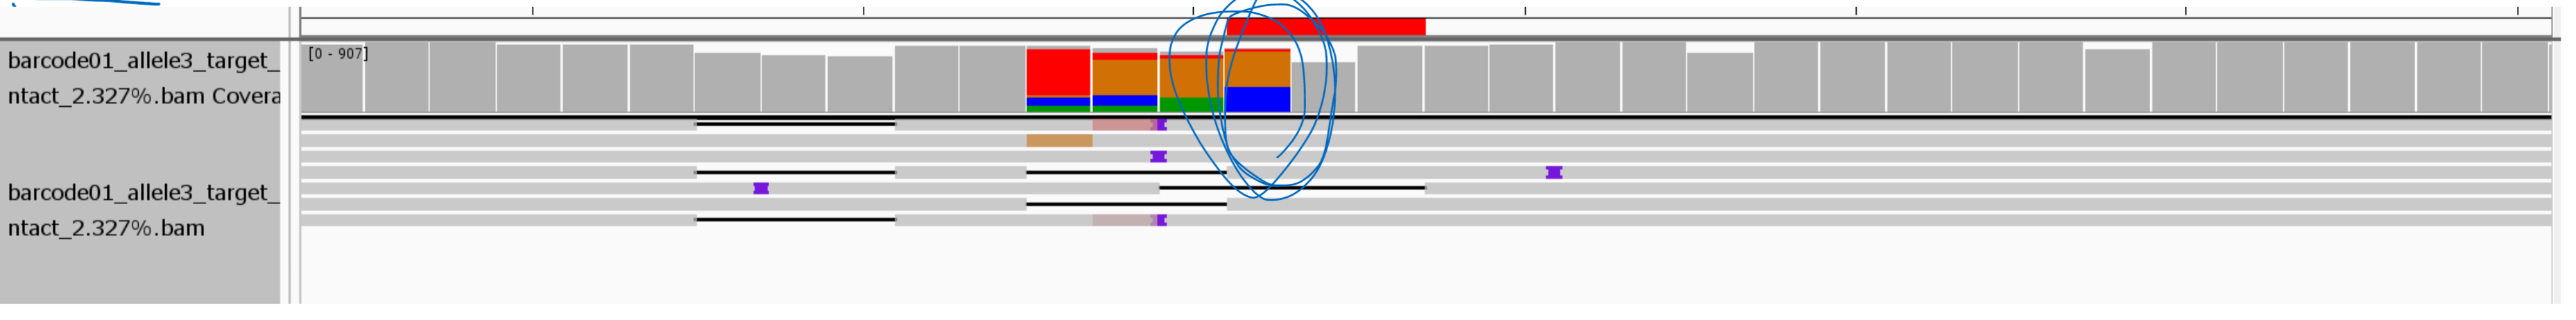

In [ ]:
### Lists

+ GUIの見栄え
+ igv.jsの起動
+ VCFによる長鎖挿入・欠失情報の付与
+ Figの作成
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ✅ Tyrの動作確認
+ ✅ ayabe-task1のleft/right-loxpの検出
+ ✅ mutation_lociをpreprocessで使用したものに変更する
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする